In [32]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [16]:
# Read data
data = pd.read_csv('Lending_Club_Data.csv')

In [17]:
# Data cleaning
data = data.drop(
    ['emp_title', 'dti_joint', 'dti', 'dti_joint.1', 'int_rate', 'recoveries', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'tax_liens', 'verification_status_joint',], axis=1)
data = data.fillna(0)
for i in data.columns:  # For column in used to be str, convert 0 to '0'
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('str')

In [18]:
# Numerating non-numerical data
encoder = preprocessing.OrdinalEncoder()
encoder.fit(data)
df = pd.DataFrame(encoder.transform(data), columns=data.columns)

In [19]:
# Train-test split
random_state = 809
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1),
                                                    df['loan_status'], test_size=0.3,
                                                    random_state=random_state)

In [10]:
oversample = SMOTE(random_state=random_state, k_neighbors=1, n_jobs=-1)
oversampled_X_train, oversampled_y_train = oversample.fit_resample(X_train, y_train)

In [24]:
import statsmodels.api as sm
lm = sm.Logit(oversampled_y_train, oversampled_X_train)
lm_r = lm.fit()
print(lm_r.summary())

Optimization terminated successfully.
         Current function value: 0.622558
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               911890
Model:                          Logit   Df Residuals:                   911851
Method:                           MLE   Df Model:                           38
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                  0.1018
Time:                        20:45:26   Log-Likelihood:            -5.6770e+05
converged:                       True   LL-Null:                   -6.3207e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
loan_amnt             -5.956e-05   3.41e-05     -1.747      0.081      -0.000    7.26e

In [26]:
oversampled_X_train = oversampled_X_train.drop(['verification_status', 'num_bc_tl', 'num_tl_90g_dpd_24m',
                                                'pub_rec_bankruptcies', 'revol_bal'], axis=1)
X_test = X_test.drop(['verification_status', 'num_bc_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'revol_bal'], axis=1)

In [28]:
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)
rfc.fit(oversampled_X_train, oversampled_y_train)

RandomForestClassifier(n_jobs=-1, random_state=809)

0.7210467343766943


/Users/goldenjerry/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/goldenjerry/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


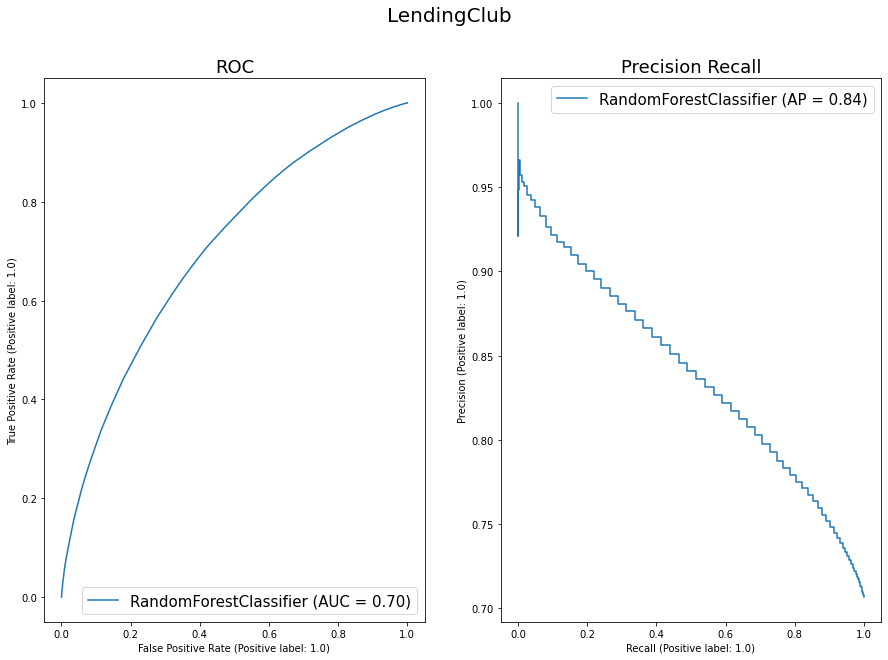

In [29]:
# Evaluation
print(rfc.score(X_test, y_test))
confusion_matrix = confusion_matrix(y_test, rfc.predict(X_test))
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 10))
plot_roc_curve(rfc, X_test, y_test, ax=ax)
plot_precision_recall_curve(rfc, X_test, y_test, ax=ax1)
ax.set_title('ROC', fontsize=18)
ax1.set_title('Precision Recall', fontsize=18)
ax.legend(fontsize=15)
ax1.legend(fontsize=15)
plt.suptitle('LendingClub', fontsize=20)
plt.show()

In [ ]:
# Parameter optimisation
n_estimators = [200, 500, 1000, 2000]
max_features = ['sqrt', 0.5]
max_depth = [10, 20, 50, 100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)
n_iter = 10 # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
cv = 3 # Cross-validation folds
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions =param_grid, n_iter = n_iter, cv = cv,
                               random_state=random_state, n_jobs = -1, scoring='average_precision')
time_start = time.time()
rf_random.fit(oversampled_X_train, oversampled_y_train)
time_end = time.time()
print('time cost', time_end - time_start, 's')

In [36]:
best_parameters = rf_random.best_params_
print('The best Parameters are:')
for key, item in best_parameters.items():
    print(f'- {key}: {item}')

The best Parameters are:
- n_estimators: 1000
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: sqrt
- max_depth: 100


[[ 19540  61645]
 [ 14310 181175]]


/Users/goldenjerry/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


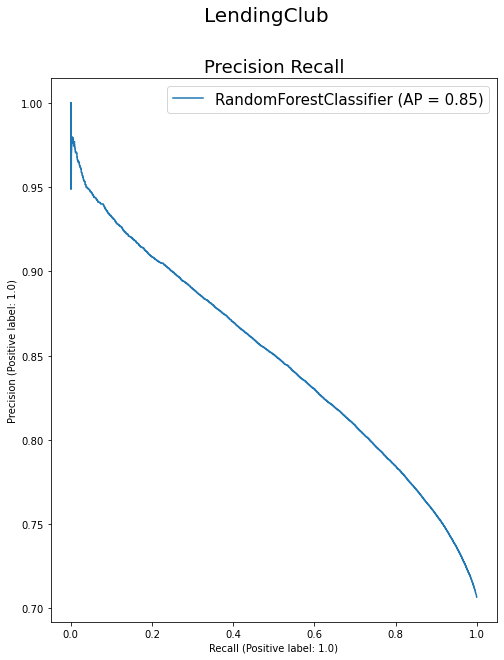

In [41]:
rfc_opt = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features = 'sqrt',
                                 max_depth=100, random_state=random_state, n_jobs=-1)
rfc_opt.fit(oversampled_X_train, oversampled_y_train)
print(rfc_opt.score(X_test, y_test))
confusion_matrix = confusion_matrix(y_test, rfc_opt.predict(X_test))
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 10))
plot_roc_curve(rfc_opt, X_test, y_test, ax=ax)
plot_precision_recall_curve(rfc_opt, X_test, y_test, ax=ax1)
ax.set_title('ROC', fontsize=18)
ax1.set_title('Precision Recall', fontsize=18)
ax.legend(fontsize=15)
ax1.legend(fontsize=15)
plt.suptitle('LendingClub', fontsize=20)
plt.show()